# Some ideas for spectral MC Simulations

In [1]:
import luxpy as lx
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

%matplotlib inline


from empir19nrm02.spectral import McSpectrumX, generate_FourierMC0
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
                              array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result, sumMC
from empir19nrm02.f1prime import py_f1PrimeG,  py_f1PrimeGlx

# Parameter for the simulation
#### Let's modify some standard data first and caculate some integrated valeus like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 10000

bIdeal = True
selected_detector = 73

fig_number = 1
fig_type= '.svg'
table_type= '.csv'

def get_fig_file_name(filename=None, table=False):
    global fig_number
    global fig_type
    global bIdeal
    if bIdeal:
        strIdeal = 'DIdeal'
    else:
        strIdeal = 'D' + str(selected_detector)
    if filename is None:
        file_name = r'met\Fig' + strIdeal + str(fig_number) + fig_type
        fig_number+=1
    else:
        if table:
            file_name = r'met\Table' + strIdeal + filename + table_type
        else:
            file_name = r'met\Fig' + strIdeal + filename + fig_type
    return file_name

def save_fig(filename=None):
    return pyplot.savefig( get_fig_file_name(filename), bbox_inches='tight', pad_inches=0)

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function)


In [3]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector and sore all together into a class instance SPD from luxpy

In [4]:
if bIdeal:
    wl=lxCmfInterpolate[0].reshape(1,res)
    value=lxCmfInterpolate[2].reshape(1,res)
    spd_init = np.r_[wl, value]
else:
    from empir19nrm02 import _RES
    wl= _RES['VLDetectors']['S']['data'][0].copy()
    value= _RES['VLDetectors']['S']['data'][73].copy()
    res_tmp = wl.shape[0]
    wl=wl.reshape(1,res_tmp)
    value=value.reshape(1,res_tmp)
    spd_org = np.r_[wl, value]
    spd_init = lx.cie_interp(spd_org, \
        wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
        kind = 'S')


# Scale to reference?
True    all graphs will be shown as difference to the reference
False   all graphs will be shown as they are (without referencing the data)

In [5]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The useage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

In [6]:
mc_enable = { 'nothing': True,
              'wl_noise_nc': True,
              'wl_noise_c': True,
              'wl_fourier_noise':True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'value_fourier_noise':True,
              'all': True,
              }

### Array containing instances of the class SPD to store the results of the MC simulation

In [7]:
array_mc = np.ndarray((trials,),dtype=object)

### Array containing the integral results (here $f_{1}^{'}$ for an/multiple scalar output)

In [8]:
result1 = np.zeros( (6, trials))

### Array containing the integral results (here Yxy for a more-dimensional  output)

In [9]:
result3 = np.zeros( (3, trials))

# Running the MC simulation

In [10]:
def MC_simulation(mc_enable_loc):
    global array_mc
    global result1
    global result3

    class mc_budget_table:
        name = 'empty'
        mean = 0.0
        stddev = 0.0
        nb = 0
        dist = ''
        Y = 0
        x = 0
        y = 0
        sY = 0
        sx = 0
        sy = 0
        f1p=0
        f1pE=0
        f1pL=0
        f1pMin=0
        f1ppR=0
        f1pBW=0
        sf1p=0
        sf1pE=0
        sf1pL=0
        sf1pMin=0
        sf1ppR=0
        sf1pBW=0

    print(mc_enable_loc)
    #mc_budget_table_array
    mc_bta_loc = [mc_budget_table() for i in mc_enable_loc]

    #for iMC in ['all']:
    for iMC in mc_enable_loc:
        # do nothing if a contribution is not enabled
        if mc_enable_loc[iMC] == False: continue

        # initialise the result data arrays
        result1.fill(0)
        result3.fill(0)

        # init the spectral array with the reference distribution to add some noise later on
        for i in range(trials):
            array_mc[i] = McSpectrumX(spd_init)

        # for all trials
        d_nb = 0
        d_mean = 0
        d_stddev = 0
        d_dist = 'none'
        for i in range(0, trials):
            # no noise for the first item as reference for later investigations
            if i != 0:
                if mc_enable_loc['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'normal'
                    array_mc[i].add_wl_noise_nc( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'normal'
                    array_mc[i].add_wl_noise_c( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['wl_fourier_noise'] and (iMC == 'wl_fourier_noise' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 1
                    d_dist = 'F'
                    d_nb = 4
                    array_mc[i].add_wl_fourier_noise( array_mc[0], d_nb, stddev=1.)

                if mc_enable_loc['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'normal'
                    array_mc[i].add_value_noise_nc( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'normal'
                    array_mc[i].add_value_noise_c( d_mean, d_stddev, distribution=d_dist)
                if mc_enable_loc['value_fourier_noise'] and (iMC == 'value_fourier_noise' or iMC == 'all'):
                    d_mean = 0
                    d_stddev = 0.01
                    d_dist = 'F'
                    d_nb = 4
                    array_mc[i].add_value_fourier_noise( array_mc[0], d_nb, stddev=d_stddev)

            # calculate some sample integral data from the generated distribution

            [result1[0, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A')
            [result1[1, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='E')
            [result1[2, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='LED_B3')
            [result1[3, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A', iMin=True)
            [result1[4, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='E', dCutOff=-0.003)
            [result1[5, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A', dBandWidth=20.)
            result3[:,i] = lx.xyz_to_Yxy(array_mc[i].spd.to_xyz(relative=False).value)


        print("i=", iMC)

        if iMC=='all':
            # Show all the graphs only for the final result
            if mc_enable_loc['wl_noise_nc'] == True and mc_enable_loc['value_noise_nc'] == False:
                analyse = array2analyse(array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
                print('Statistic for the wavelength scale')
                analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
                save_fig(filename='MC_wl_All')
                plotHistScalesWl( analyse)

            if mc_enable_loc['value_noise_nc'] == True and mc_enable_loc['wl_noise_nc'] == False :
                analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                print('Statistic for the value scale')
                analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                save_fig(filename='MC_value_All')
                plotHistScalesValue( analyse)
        # Calculate the sensitivity
        idx = list(mc_enable_loc.keys()).index(iMC)
        mc_bta_loc[idx].name = iMC
        erg=np.mean(result3, axis=1)
        mc_bta_loc[idx].Y=erg[0]
        mc_bta_loc[idx].x=erg[1]
        mc_bta_loc[idx].y=erg[2]
        serg=np.std(result3, axis=1)
        mc_bta_loc[idx].sY=serg[0]
        mc_bta_loc[idx].sx=serg[1]
        mc_bta_loc[idx].sy=serg[2]

        erg=np.mean(result1, axis=1)
        mc_bta_loc[idx].f1p=erg[0]
        mc_bta_loc[idx].f1pE=erg[1]
        mc_bta_loc[idx].f1pL=erg[2]
        mc_bta_loc[idx].f1pMin=erg[3]
        mc_bta_loc[idx].f1ppR=erg[4]
        mc_bta_loc[idx].f1pBW=erg[5]
        serg=np.std(result1, axis=1)
        mc_bta_loc[idx].sf1p=serg[0]
        mc_bta_loc[idx].sf1pE=serg[1]
        mc_bta_loc[idx].sf1pL=serg[2]
        mc_bta_loc[idx].sf1pMin=serg[3]
        mc_bta_loc[idx].sf1ppR=serg[4]
        mc_bta_loc[idx].sf1pBW=serg[5]
        if iMC!='all':
            mc_bta_loc[idx].mean = d_mean
            mc_bta_loc[idx].stddev = d_stddev
            mc_bta_loc[idx].dist = d_dist
            mc_bta_loc[idx].nb = d_nb
    return mc_bta_loc

# Simulation for the wavelength scale

{'nothing': False, 'wl_noise_nc': True, 'wl_noise_c': True, 'wl_fourier_noise': True, 'value_noise_nc': False, 'value_noise_c': False, 'value_fourier_noise': False, 'all': True}
i= wl_noise_nc
i= wl_noise_c
i= wl_fourier_noise
i= all
Statistic for the wavelength scale
Value= [0.027003907856479596, 1.9616392618155933] Inteval(95%)= 7.633205053455185
Value= [0.027003907856479596, 1.9616392618155933] Inteval(95%)= 7.633205053455185


F:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


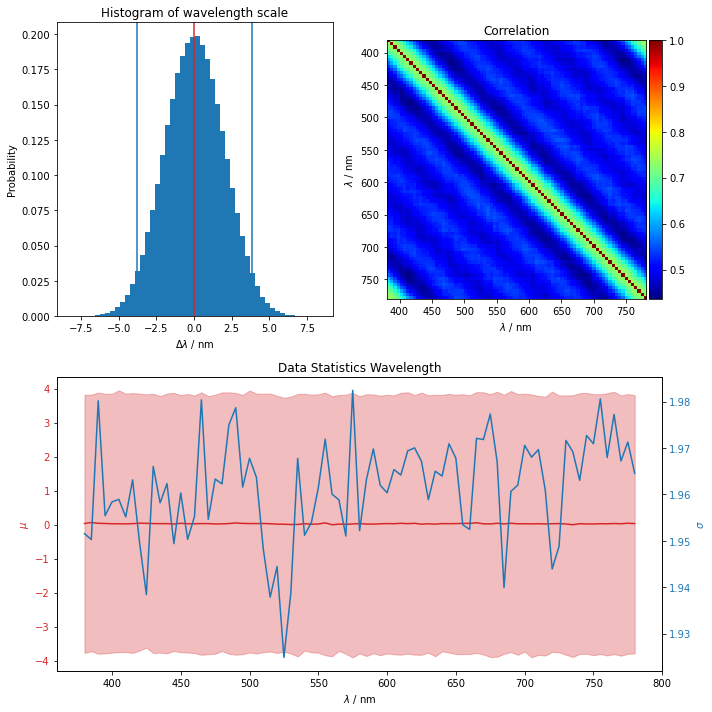

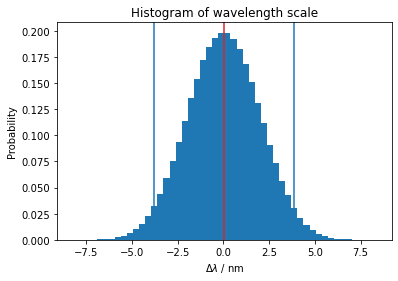

In [11]:
mc_wl = mc_enable.copy()
for key in mc_wl:
    mc_wl[key]=False
mc_wl['wl_noise_c']=True
mc_wl['wl_noise_nc']=True
mc_wl['wl_fourier_noise']=True
mc_wl['all']=True

mc_bta=MC_simulation( mc_wl)

# Simulation for the value scale

{'nothing': False, 'wl_noise_nc': False, 'wl_noise_c': False, 'wl_fourier_noise': False, 'value_noise_nc': True, 'value_noise_c': True, 'value_fourier_noise': True, 'all': True}
i= value_noise_nc
i= value_noise_c
i= value_fourier_noise
i= all
Statistic for the value scale
Value= [0.00013002813795036258, 0.015343241344942407] Inteval(95%)= 0.060466839142920475
Value= [0.00013002813795036258, 0.015343241344942407] Inteval(95%)= 0.060466839142920475


F:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


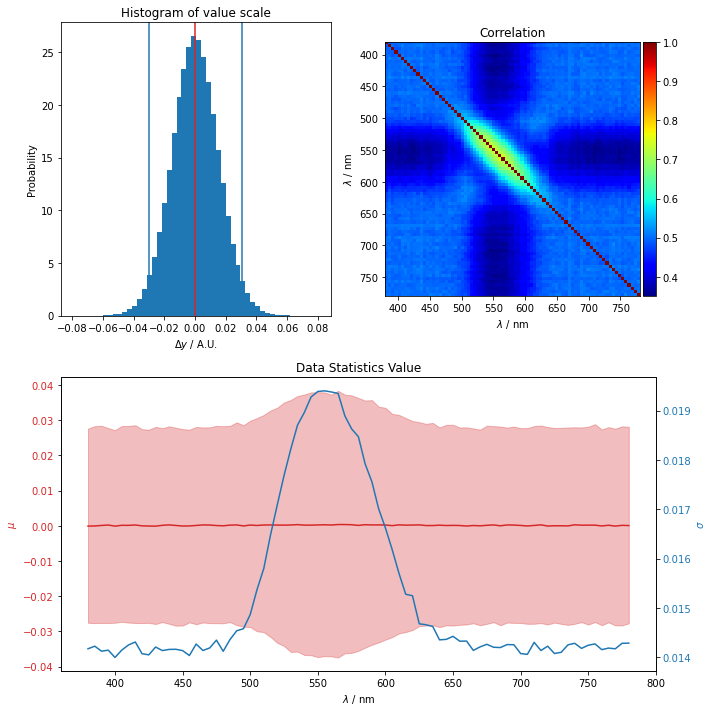

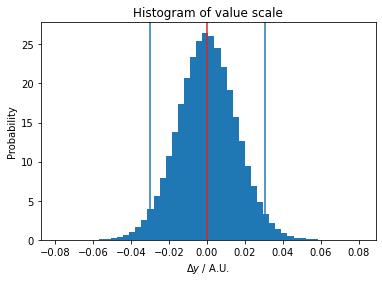

In [12]:
mc_value = mc_enable.copy()
for key in mc_value:
    mc_value[key]=False
mc_value['value_noise_c']=True
mc_value['value_noise_nc']=True
mc_value['value_fourier_noise']=True
mc_value['all']=True

mc_bta=MC_simulation( mc_value)

# Simulation for the all together

In [13]:
mc_all = mc_enable.copy()
mc_bta=MC_simulation( mc_all)

{'nothing': True, 'wl_noise_nc': True, 'wl_noise_c': True, 'wl_fourier_noise': True, 'value_noise_nc': True, 'value_noise_c': True, 'value_fourier_noise': True, 'all': True}
i= nothing
i= wl_noise_nc
i= wl_noise_c
i= wl_fourier_noise
i= value_noise_nc
i= value_noise_c
i= value_fourier_noise
i= all


In [14]:
eps=1e-6

def t_out( number, sigfigs=4):
    if abs(number)<eps:
        return round(str(number), decimals=sigfigs)
    else:
        return round(str(number), sigfigs=sigfigs)

import pyperclip
from prettytable import PrettyTable
from sigfig import round

x_table = PrettyTable()
x_table.field_names = ["Contribution", "Mean", "Std. Dev.", "NB", "Distribution",
                       #"Y","x","y", "sY","sx","sy",
                       "f1p","f1pE","f1pL","f1pMin","f1ppR","f1pBW","sf1p","sf1pE","sf1pL","sf1pMin","sf1ppR","sf1pBW"]

MCTable = pd.DataFrame()
for i in mc_enable:
    idx = list(mc_enable.keys()).index(i)
    if i == 'all':
        x_table.add_row([mc_bta[idx].name, '', '',
                         '', '',
                        #t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        #t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy, 2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].sf1p, 2),
                        t_out(mc_bta[idx].f1pE), t_out(mc_bta[idx].sf1pE, 2),
                        t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].sf1pL, 2),
                        t_out(mc_bta[idx].f1pMin), t_out(mc_bta[idx].sf1pMin, 2),
                        t_out(mc_bta[idx].f1ppR), t_out(mc_bta[idx].sf1ppR, 2),
                        t_out(mc_bta[idx].f1pBW), t_out(mc_bta[idx].sf1pBW, 2)])
    else:
        x_table.add_row([mc_bta[idx].name, mc_bta[idx].mean, mc_bta[idx].stddev,
                         mc_bta[idx].nb, mc_bta[idx].dist,
                        #t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        #t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy,2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].sf1p, 2),
                        t_out(mc_bta[idx].f1pE), t_out(mc_bta[idx].sf1pE, 2),
                        t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].sf1pL, 2),
                        t_out(mc_bta[idx].f1pMin), t_out(mc_bta[idx].sf1pMin, 2),
                        t_out(mc_bta[idx].f1ppR), t_out(mc_bta[idx].sf1ppR, 2),
                        t_out(mc_bta[idx].f1pBW), t_out(mc_bta[idx].sf1pBW, 2)])

    df = pd.DataFrame( { \
         'Contributon': [mc_bta[idx].name], \
         'Mean':mc_bta[idx].mean,
         'StdDev':mc_bta[idx].stddev,
         'NB':mc_bta[idx].nb,
         'Distribution':mc_bta[idx].dist,
         'f1p':mc_bta[idx].f1p,
         'sf1p':mc_bta[idx].sf1p,
         'f1pE':mc_bta[idx].f1pE,
         'sf1pE':mc_bta[idx].sf1pE,
         'f1pL':mc_bta[idx].f1pL,
         'sf1pL':mc_bta[idx].sf1pL,
         'f1pMin':mc_bta[idx].f1pMin,
         'sf1pMin':mc_bta[idx].sf1pMin,
         'f1ppR':mc_bta[idx].f1ppR,
         'sf1ppR':mc_bta[idx].sf1ppR,
         'f1pBW':mc_bta[idx].f1pBW,
         'sf1pBW':mc_bta[idx].sf1pBW,
          } )
    MCTable = MCTable.append( df)

print(x_table)

MCTable
MCTable.to_csv(get_fig_file_name('MCStandard', table=True), sep=';',  decimal=",")

+---------------------+------+-----------+----+--------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+---------+----------+--------+
|     Contribution    | Mean | Std. Dev. | NB | Distribution |   f1p    |  f1pE  |   f1pL   | f1pMin |  f1ppR   | f1pBW  |   sf1p   | sf1pE  |  sf1pL   | sf1pMin |  sf1ppR  | sf1pBW |
+---------------------+------+-----------+----+--------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+---------+----------+--------+
|       nothing       |  0   |     0     | 0  |     none     |  0.0000  |  0.00  |  0.0000  |  0.00  |  0.0000  |  0.00  |  0.0000  |  0.00  |  0.0000  |   0.00  |  0.0000  |  0.00  |
|     wl_noise_nc     |  0   |     1     | 0  |    normal    | 0.01511  | 0.0020 | 0.01509  | 0.0020 | 0.01504  | 0.0020 | 0.01480  | 0.0020 | 0.002441 |  0.0016 | 0.006320 | 0.0017 |
|      wl_noise_c     |  0   |     1     | 0  |    normal    | 0.01540  | 0.011 

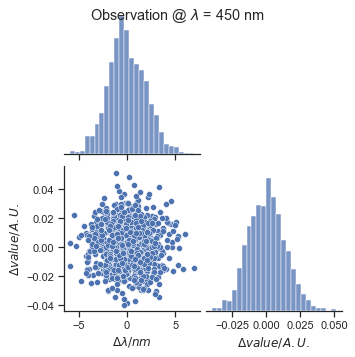

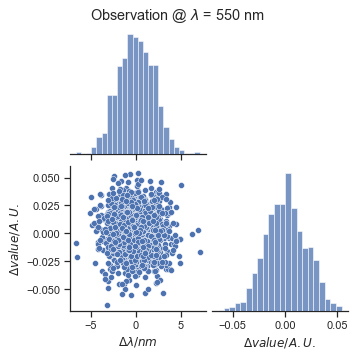

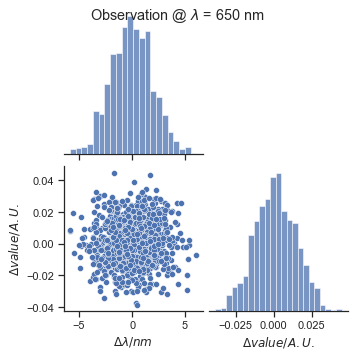

In [15]:
seaborn_plot_basedata(array_mc, wavelength_to_observe = 450)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 550)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 650)

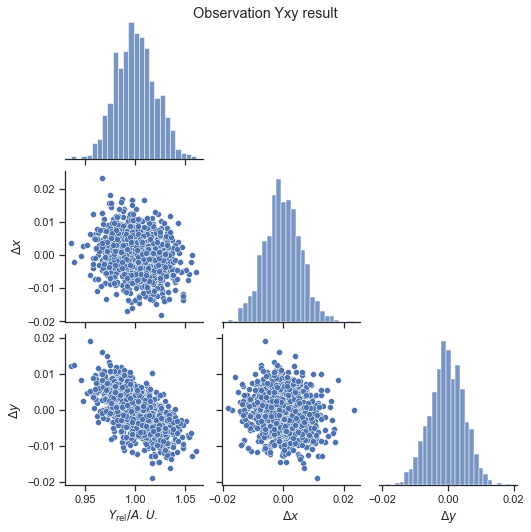

In [16]:
seaborn_plot_result( result3)

In [17]:
def seaborn_plot_result_f1prime(loc_result):
    disp_array_count = loc_result.shape[1]
    #step=int(trials/200) + 1
    step=1
    disp_test = loc_result[0, 1::step]
    disp_array = np.zeros((6, disp_test.shape[0]))
    for i in range(6):
        disp_array[i] = loc_result[i, 1::step] - loc_result[i, 0]
    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T,
                      columns=['$\Delta f_{1}^{´}$', '$\Delta f_{1,\mathrm{E}}^{´}$', '$\Delta f_{1,\mathrm{L}}^{´}$',
                               '$\Delta f_{1,\mathrm{Min}}^{´}$', '$\Delta f_{1,\mathrm{R}}^{´´}$', '$\Delta f_{1,\mathrm{BW=20nm}}^{´}$', ])
    grid = sns.pairplot(df, corner=True, kind="hist")

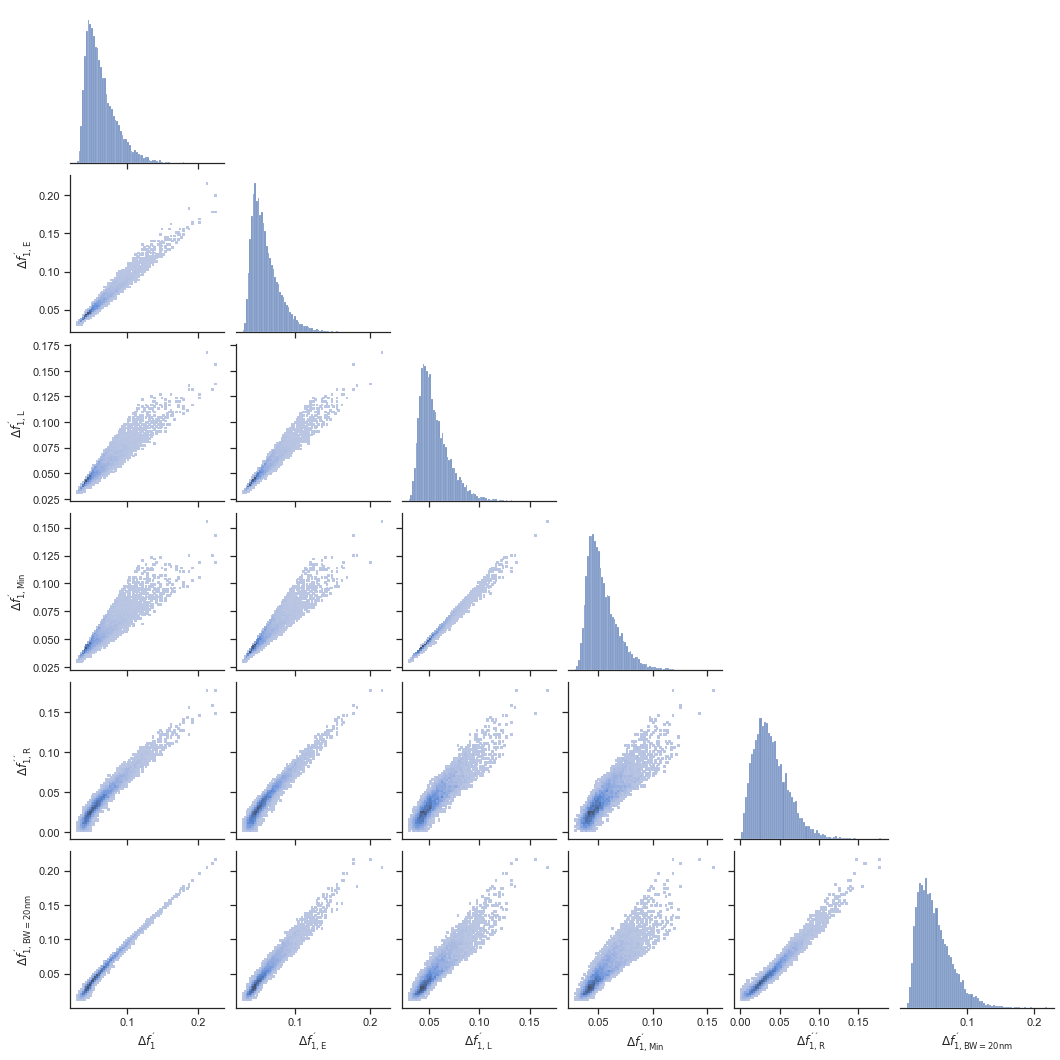

In [18]:
seaborn_plot_result_f1prime( result1)
save_fig( 'MCf1Results')

In [19]:
def FourierTableP( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ)
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / np.mean(L), Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'L_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'CCT_mean': CCTvalues[0], 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'x_mean': xvalues[0], 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'y_mean': yvalues[0], 'y_std': yvalues[1], 'x_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')
        petriTable = petriTable.append( df)
        print( numberNew)
    return petriTable


def FourierTablef1p( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))

    start_data =np.r_[ wl.reshape(1,wl.shape[0]), SPD.reshape(1,wl.shape[0])]
    f1p0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pE0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pL0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pMin0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    f1ppR0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
    f1pBW0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        f1p=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pE=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pL=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pMin=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
        f1ppR=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
        f1pBW=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)

        [f1p_values, f1p_interval] = sumMC(f1p, Coverage=0.95)
        [f1pE_values, f1pE_interval] = sumMC(f1pE, Coverage=0.95)
        [f1pL_values, f1pL_interval] = sumMC(f1pL, Coverage=0.95)
        [f1pMin_values, f1pMin_interval] = sumMC(f1pMin, Coverage=0.95)
        [f1ppR_values, f1ppR_interval] = sumMC(f1ppR, Coverage=0.95)
        [f1pBW_values, f1pBW_interval] = sumMC(f1pBW, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'df1p': f1p_values[0]-f1p0, 'f1p_std': f1p_values[1], 'f1p_95%': (f1p_interval[1]-f1p_interval[0])/2., \
            'df1pE': f1pE_values[0]-f1pE0, 'f1pE_std': f1pE_values[1], 'f1pE_95%': (f1pE_interval[1]-f1pE_interval[0])/2., \
            'df1pL': f1pL_values[0]-f1pL0, 'f1pL_std': f1pL_values[1], 'f1pL_95%': (f1pL_interval[1]-f1pL_interval[0])/2., \
            'df1pMin': f1pMin_values[0]-f1pMin0, 'f1pMin_std': f1pMin_values[1], 'f1pMin_95%': (f1pMin_interval[1]-f1pMin_interval[0])/2., \
            'df1ppR': f1ppR_values[0]-f1ppR0, 'f1ppR_std': f1ppR_values[1], 'f1ppR_95%': (f1ppR_interval[1]-f1ppR_interval[0])/2., \
            'df1pBW': f1pBW_values[0]-f1pBW0, 'f1pBW_std': f1pBW_values[1], 'f1pBW_95%': (f1pBW_interval[1]-f1pBW_interval[0])/2., \
             } , dtype = 'float')
        petriTable = petriTable.append( df)
        print( numberNew)
    return petriTable
'''
illA = lx._CIE_ILLUMINANTS['A'].copy()
res_illA = illA.shape[1]
# relative to 560nm
illA[1] = illA[1] / illA[1, np.argwhere(illA[0]==560)]
uSPD=np.zeros(res_illA)
uSPD[:]=0.01

petriTable=FourierTableP(10000, illA[0], illA[1], uSPD)
petriTable
'''

[f1pOrg, _]=py_f1PrimeG(spd_init[0], spd_init[1], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
print('f1pOrg=', f1pOrg)
res_VL = spd_init[0].shape[0]
uSPD=np.zeros(res_VL)
uSPD[:]=0.01

petriTable=FourierTablef1p(100, spd_init[0], spd_init[1], uSPD)
petriTable
if False:
    petriTable.to_csv(get_fig_file_name('Fourierf1p', table=True), sep=';',  decimal=",")

f1pOrg= 8.574194362610059e-17
0
1
2
3
4
5
6
7
8
9
10
20
30
40
42
50
60
70
80
90
100
150
200
235


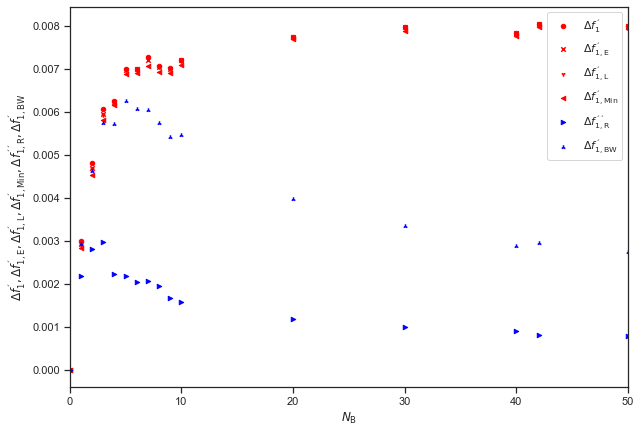

In [20]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="df1p", marker='o', color="Red", label="$\Delta f_{1}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pE", marker='x', color="Red", label="$\Delta f_{1,\mathrm{E}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pL", marker='1', color="Red", label="$\Delta f_{1,\mathrm{L}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pMin", marker='<', color="Red", label="$\Delta f_{1,\mathrm{Min}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1ppR", marker='>', color="Blue", label="$\Delta f_{1,\mathrm{R}}^{´´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pBW", marker='2', color="Blue", label="$\Delta f_{1,\mathrm{BW}}^{´}$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$')
ax1.set_ylabel('$\Delta f_{1}^{´}, \Delta f_{1,\mathrm{E}}^{´}, \Delta f_{1,\mathrm{L}}^{´},  \Delta f_{1,\mathrm{Min}}^{´}, \Delta f_{1,\mathrm{R}}^{´´}, \Delta f_{1,\mathrm{BW}}^{´} $')
ax1.set_xlim([0,50])

if False:
    save_fig('f1pTableFourier')


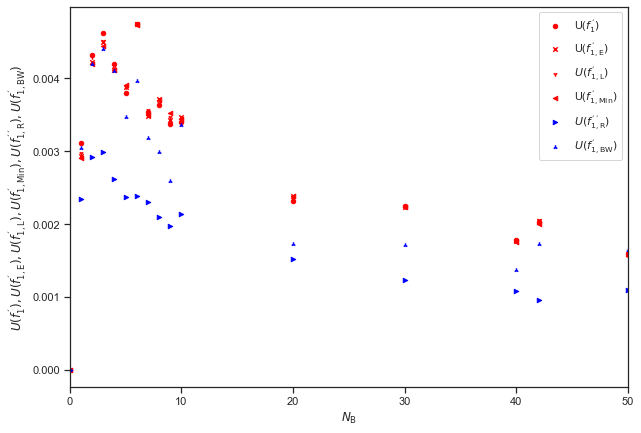

In [21]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="f1p_95%", marker='o', color="Red", label="U($f_{1}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pE_95%", marker='x', color="Red", label="U($f_{1, \mathrm{E}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pL_95%", marker='1', color="Red", label="$U(f_{1,\mathrm{L}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pMin_95%", marker='<', color="Red", label="U($f_{1, \mathrm{Min}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1ppR_95%", marker='>', color="Blue", label="$U(f_{1,\mathrm{R}}^{´´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pBW_95%", marker='2', color="Blue", label="$U(f_{1,\mathrm{BW}}^{´})$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$')
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{E}}^{´}), U(f_{1,\mathrm{L}}^{´}),  U(f_{1,\mathrm{Min}}^{´}), U(f_{1,\mathrm{R}}^{´´}), U(f_{1,\mathrm{BW}}^{´})$')
ax1.set_xlim([0,50])
if False:
    save_fig('Uf1pTableFourier')
